In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [239]:
# import data
file = 'Data_v1.xlsx'
# transpose the data the data
data = pd.read_excel(file, index_col=0).transpose()
# drop columns without any value
data_new = data.loc[:,data.columns.notnull()]
X_cat = data_new[['Requires extensive machining or Tight tolerance (0.08-0.1mm)?','Max batch size','Easy post-processing?','Heat treatment required if 3D printed?']]
data_temp = data_new.drop(['Requires extensive machining or Tight tolerance (0.08-0.1mm)?','Max batch size','Easy post-processing?','Heat treatment required if 3D printed?'],axis=1)
X_num = data_temp.drop(['Label'],axis=1)
y_data = data_temp['Label']

In [195]:
# check for any null 
data_temp.isnull().any()

Features
Functional surface (FS) (mm2)    False
Overall surface (OS) (mm2)       False
FS/OS                            False
Part volume (mm3)                False
Bounding box volume              False
PV/BV                            False
Aspect ratio                     False
Minimum feature size             False
Label                            False
dtype: bool

In [240]:
columns = data_new.columns.drop('Label')

In [241]:
X_num=np.log10(X_num)
X_data=pd.DataFrame(np.concatenate([X_num,X_cat],axis=1))
X_data.columns = columns

## Visualization

Reference: https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2 <br>
Boxplot: https://www.simplypsychology.org/boxplots.html

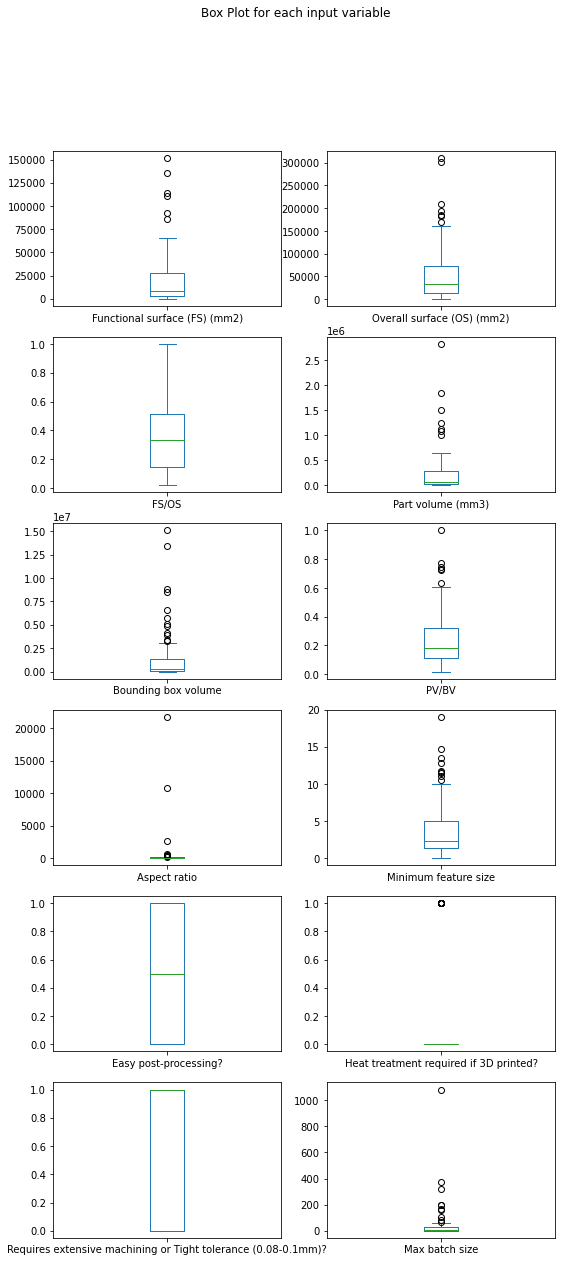

In [252]:
data_new.drop('Label',axis=1).plot(kind='box',
                                    subplots=True,
                                    layout=(6,2),
                                   sharex=False,
                                   sharey=False,
                                   figsize=(9,20),
                                   title='Box Plot for each input variable')
#plt.savefig('input_box')
plt.show()

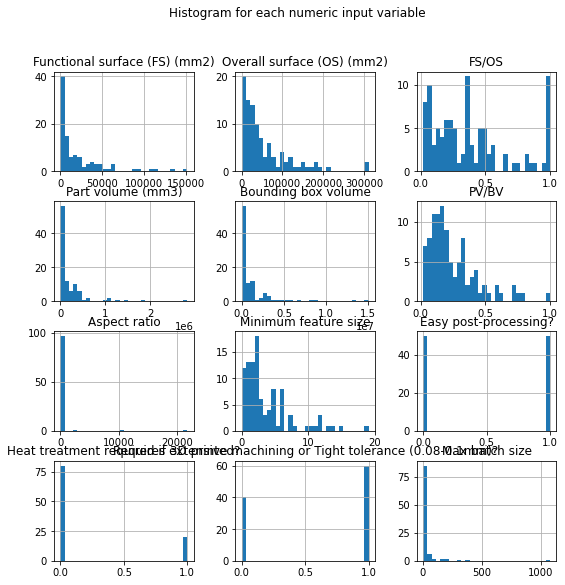

In [247]:
import pylab as pl
data_new.drop('Label',axis=1).hist(bins=30,figsize=(9,9))
pl.suptitle('Histogram for each numeric input variable')
plt.show()

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

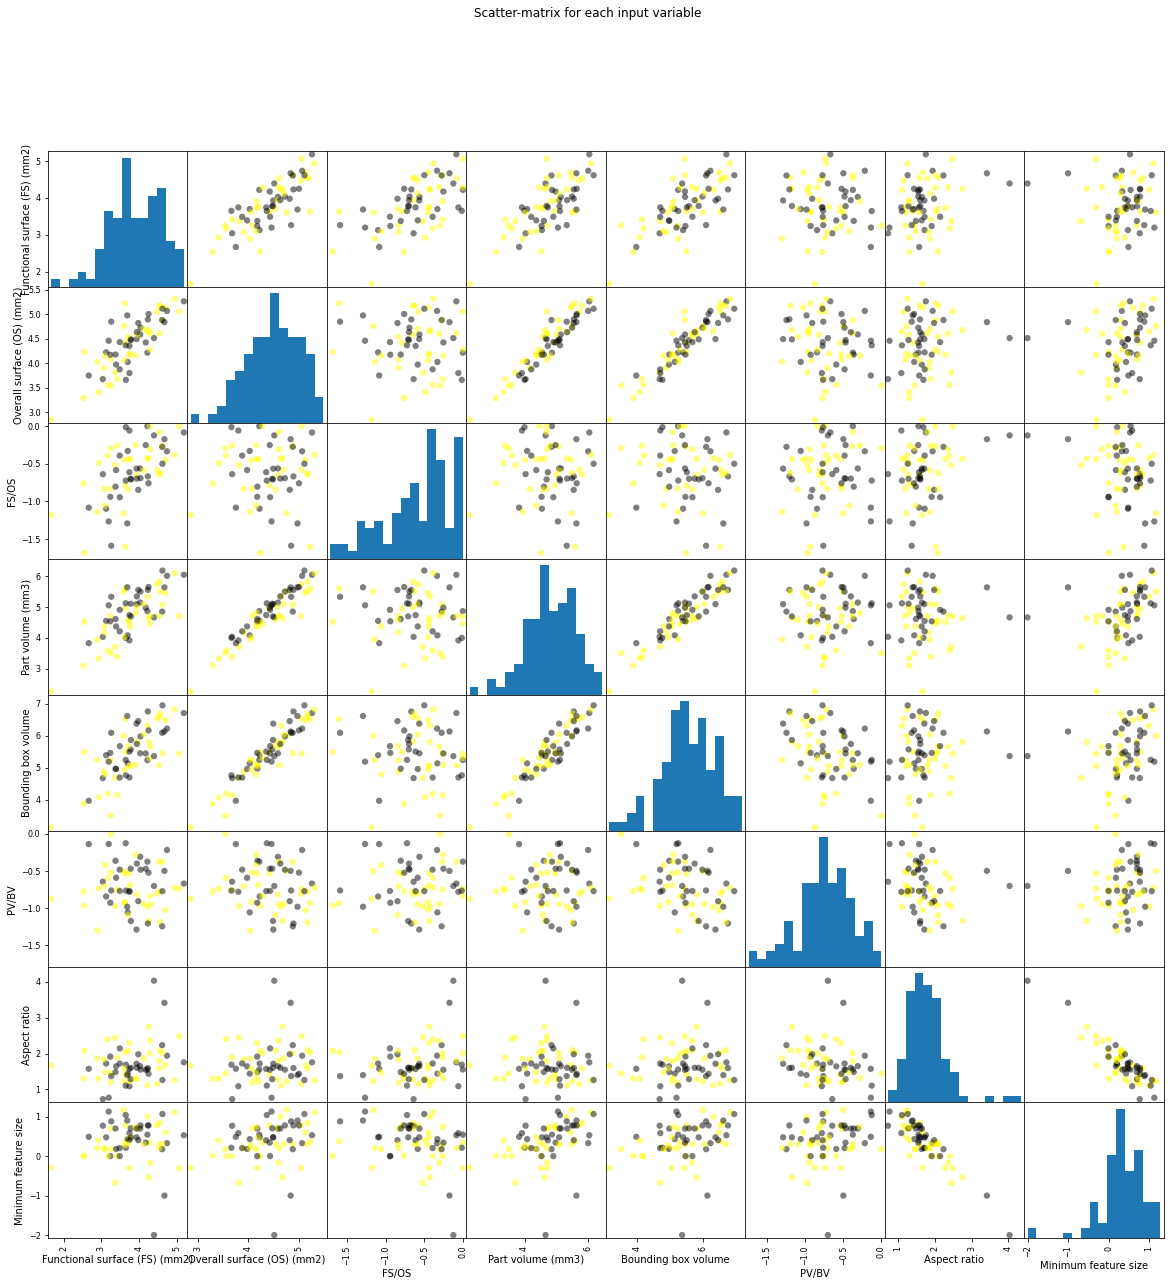

In [134]:
# correlations
from pandas.plotting import scatter_matrix
from matplotlib import cm

X = data_temp.drop(['Label'],axis=1)
Y = data_temp['Label']

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X,c=Y,marker='o',s=40,
                           hist_kwds={'bins':15},figsize=(20,20),
                           cmap=cmap)
plt.suptitle('Scatter-matrix for each input variable')


In [141]:
data_temp.describe()

Features,Functional surface (FS) (mm2),Overall surface (OS) (mm2),FS/OS,Part volume (mm3),Bounding box volume,PV/BV,Aspect ratio,Minimum feature size,Label
count,100.000000,100.00000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,21149.853454,55948.65857,0.387034,2.281282e+05,1.380322e+06,0.245208,430.478588,3.704231,1.010000
std,29715.965687,61465.57906,0.301999,4.180670e+05,2.529885e+06,0.189450,2417.391586,3.651513,0.822598
min,46.560000,705.33000,0.019013,1.840600e+02,1.366870e+03,0.018220,5.328814,0.010000,0.000000
25%,2862.517500,14375.83950,0.147217,2.317894e+04,1.173755e+05,0.113903,27.424167,1.380525,0.000000
50%,8247.859000,33809.67500,0.336158,6.609439e+04,3.247230e+05,0.182958,51.316667,2.285000,1.000000
75%,28280.605675,73708.34750,0.512697,2.871466e+05,1.346384e+06,0.322143,108.145570,5.000000,2.000000
max,152115.040000,311013.74000,1.000000,2.827231e+06,1.507235e+07,1.000000,21761.000000,19.050000,2.000000


## Preprocessing

In [253]:
#split data into training and testing sets
def split_train_test(Xdata, ydata, test_ratio, rseed):
    # random
    if rseed == 0: 
        shuffled_indices = np.random.permutation(len(Xdata))
    # fixed by rseed
    else:
        shuffled_indices = np.random.RandomState(seed=rseed).permutation(len(Xdata))
    # test size 지정
    test_set_size = int(len(Xdata)*test_ratio) 
    test_indices = shuffled_indices[:test_set_size].tolist() 
    train_indices = shuffled_indices[test_set_size:].tolist()
    
    return Xdata.iloc[train_indices,:], Xdata.iloc[test_indices,:], \
ydata.iloc[train_indices], ydata.iloc[test_indices]

In [254]:
X_train, X_test, y_train, y_test = split_train_test(X_data, y_data, 0.20, 42) 

In [255]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


# cat_attribs = ['Easy post-processing?',
#               'Heat treatment required if 3D printed?',
#               'Requires extensive machining or Tight tolerance (0.08-0.1mm)?']
#num_attribs = X_data.columns.drop(cat_attribs)

scaler = MinMaxScaler()
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

# X_train_num = scaler.fit_transform(X_train[num_attribs])
# X_train_cat = enc.fit_transform(X_train[cat_attribs])
# X_train_proc = np.concatenate([X_train_num,X_train_cat],axis=1)
X_train_proc = scaler.fit_transform(X_train)

# X_test_num = scaler.transform(X_test[num_attribs])
# X_test_cat = enc.transform(X_test[cat_attribs])
# X_test_proc = np.concatenate([X_test_num,X_test_cat],axis=1)
X_test_proc = scaler.fit_transform(X_test)

## Model

In [256]:
# crossvalidations
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [257]:
## evaluation metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_mat(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues) #Reds, rainbow
    return plt.show()

## Baselines

/Users/adrianchung/tensorflow-test/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adrianchung/tensorflow-test/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

LR 40.000% +/-15.166
KNN 34.000% +/-10.677
CART 35.000% +/-10.954
SVM 33.000% +/-6.782
GBM 40.000% +/-13.784


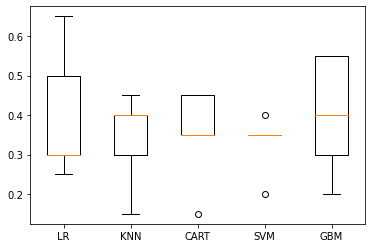

In [258]:
from numpy import mean
from numpy import std
from matplotlib import pyplot

#create a list of models to evaluate
models, names = list(),list()
#logistic
models.append(LogisticRegression())
names.append('LR')
#knn
models.append(KNeighborsClassifier())
names.append('KNN')
# cart
models.append(DecisionTreeClassifier())
names.append('CART')
# svm
models.append(SVC())
names.append('SVM')
# random forest
models.append(RandomForestClassifier())
names.append('GBM')

# evaluate models
all_scores = list()
for i in range(len(models)):
    # create a pipeline for the model
    p = Pipeline(steps=[('m',models[i])])
    scores = cross_val_score(p,X_data,y_data,scoring='accuracy', cv=5, n_jobs=-1)
    all_scores.append(scores)
    # summarize
    m, s = mean(scores)*100, std(scores)*100
    print('%s %.3f%% +/-%.3f' %(names[i], m, s))

# plot
pyplot.boxplot(all_scores, labels=names)
pyplot.show()

### KNN

In [204]:
KNN_all_scores = list()

for k in range(1,22):
    # evaluate
    model = KNeighborsClassifier(n_neighbors=k)
    KNN_model = Pipeline(steps=[('m',model)])
    KNN_model.fit(X_train_proc, y_train)
    # predict
    yhat = KNN_model.predict(X_test_proc)
    # evaluate
    score1 = accuracy_score(y_test, yhat)*100

    print('%s %.3f%%' %(str(k),score1))

1 55.000%
2 55.000%
3 55.000%
4 50.000%
5 70.000%
6 40.000%
7 50.000%
8 55.000%
9 40.000%
10 55.000%
11 40.000%
12 35.000%
13 40.000%
14 35.000%
15 45.000%
16 40.000%
17 45.000%
18 50.000%
19 45.000%
20 45.000%
21 50.000%


### SVM

In [259]:
# Search space

param_grid = {
    'C': [0.001,1,10,100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [260]:
temp_model = SVC()
svc_random = RandomizedSearchCV(estimator=temp_model,
                               param_distributions=param_grid,
                               n_iter = 100,
                               cv=5,
                               scoring = 'accuracy',
                               verbose = 2,
                               )



svc_random.fit(X_train_proc, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.001, gamma=1, k

/Users/adrianchung/tensorflow-test/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100,
                   param_distributions={'C': [0.001, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   scoring='accuracy', verbose=2)

In [262]:
# # dataset check

# for i in range(150):
#     print(i)
#     X_train, X_test, y_train, y_test = split_train_test(X_data, y_data, 0.20, i)
#     # normalize
# #     X_train_num = scaler.fit_transform(X_train[num_attribs])
# #     X_train_cat = enc.fit_transform(X_train[cat_attribs])
# #     X_train_pre = np.concatenate([X_train_num,X_train_cat],axis=1)
# #     X_test_num = scaler.transform(X_test[num_attribs])
# #     X_test_cat = enc.transform(X_test[cat_attribs])
# #     X_test_pre = np.concatenate([X_test_num,X_test_cat],axis=1)
#     X_train_pre = scaler.fit_transform(X_train)
#     X_test_pre = scaler.transform(X_test)
    
#     svc_base = SVC()
#     svc_random = RandomizedSearchCV(estimator=svc_base,
#                                    param_distributions=param_grid,
#                                    n_iter = 40,
#                                    cv=5,
#                                    verbose = 0,
#                                     scoring = 'accuracy'
#                                    )

#     svc_random.fit(X_train_pre, y_train)
#     svc_model = svc_random.best_estimator_
#     yhat = svc_model.predict(X_test_pre)
#     svc_acc = accuracy_score(y_test,yhat)*100
#     print('%.3f%%' %(svc_acc))

In [207]:
SVM_model = svc_random.best_estimator_
yhat = SVM_model.predict(X_test_proc)
SVM_acc = accuracy_score(y_test, yhat)*100
SVM_prec = precision_score(y_test, yhat, average='macro')*100
SVM_recall = recall_score(y_test,yhat,average='macro')*100
SVM_f1 = f1_score(y_test,yhat,average='macro')*100
confusion = confusion_matrix(y_test, yhat)

print('%.3f%%' %(SVM_acc))
print('%.3f%%' %(SVM_prec))
print('%.3f%%' %(SVM_recall))
print('%.3f%%' %(SVM_f1))
print(confusion)
#class_names = ['Not recommended for SLM = 0']

50.000%
48.254%
50.000%
45.719%
[[5 1 4]
 [2 1 2]
 [0 1 4]]


### Random Forest

In [208]:
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['gini', 'entropy']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

In [209]:
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1500, 2000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['gini', 'entropy'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [210]:
temp_model = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=temp_model,
                               param_distributions=rf_grid,
                               n_iter = 60,
                               cv=5,
                               scoring = 'accuracy',
                               verbose = 2,
                               )
rf_random.fit(X_train_proc, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1500; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1500; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1500; total time=   0.7s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1500; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1500; total time=   0.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=55, max_features=auto, min_impurity_decrease=0.05, min_samples_split=3, n_estim

[CV] END bootstrap=False, criterion=gini, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.2s
[CV] END bootstrap=False, criterion=gini, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.2s
[CV] END bootstrap=False, criterion=gini, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.2s
[CV] END bootstrap=False, criterion=gini, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=40, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=40, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=e

[CV] END bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=600; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=600; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=600; total time=   0.2s
[CV] END bootstrap=True, criterion

[CV] END bootstrap=False, criterion=gini, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.2s
[CV] END bootstrap=False, criterion=gini, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=1000; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=1000; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=1000; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=1000; total time=   0.4s
[CV] END bootstrap=True, criterion=gini,

[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1500; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=entropy, m

[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=2000; total time=   0.9s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=800; total time=   0.3s
[CV] END bootstrap=False, criterion=gini

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=60,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_impurity_decrease': [0.0, 0.05,
                                                                  0.1],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1500, 2000]},
                   scoring='accur

In [211]:
rf_model = rf_random.best_estimator_
#print(rf_random.best_params_)
yhat = rf_model.predict(X_test_proc)
rf_score = accuracy_score(y_test, yhat)*100
rf_score2 = precision_score(y_test, yhat,average='macro')*100
rf_recall = recall_score(y_test,yhat,average='macro')*100
rf_f1 = f1_score(y_test,yhat,average='macro')*100
confusion = confusion_matrix(y_test, yhat)

print('%.3f%%' %(rf_score))
print('%.3f%%' %(rf_score2))
print('%.3f%%' %(rf_recall))
print('%.3f%%' %(rf_f1))    
print(confusion)

35.000%
24.444%
46.667%
30.000%
[[0 3 7]
 [0 2 3]
 [0 0 5]]


/Users/adrianchung/tensorflow-test/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0, 'RF Feature Importance')

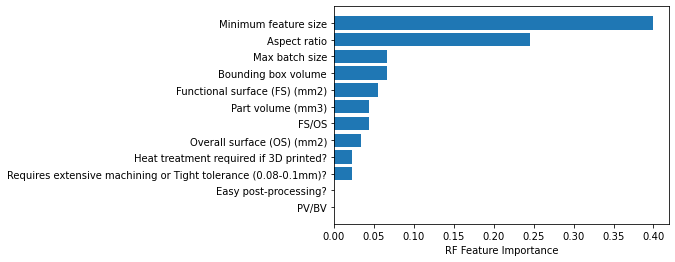

In [244]:
# check feature importance
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(X_data.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("RF Feature Importance")